<a href="https://colab.research.google.com/github/Mateo289/Signal_theory/blob/main/13_Febrero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivo CSV cargado exitosamente.
Puntos: 301 | fs: 1000.0000 Hz
f_min: 3.3223 Hz | f_max: 498.3389 Hz
Ingresa f_min (Hz): 60
Ingresa f_max (Hz): 300
Filtro: 60.0 Hz a 300.0 Hz


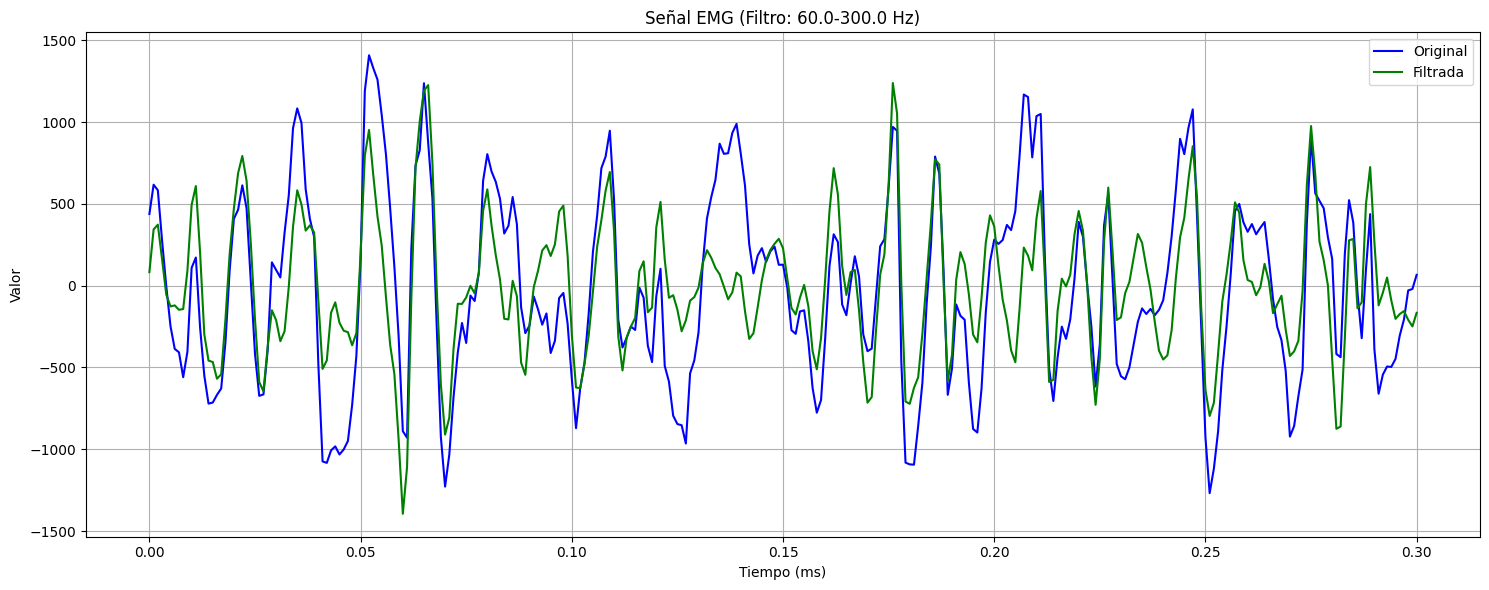

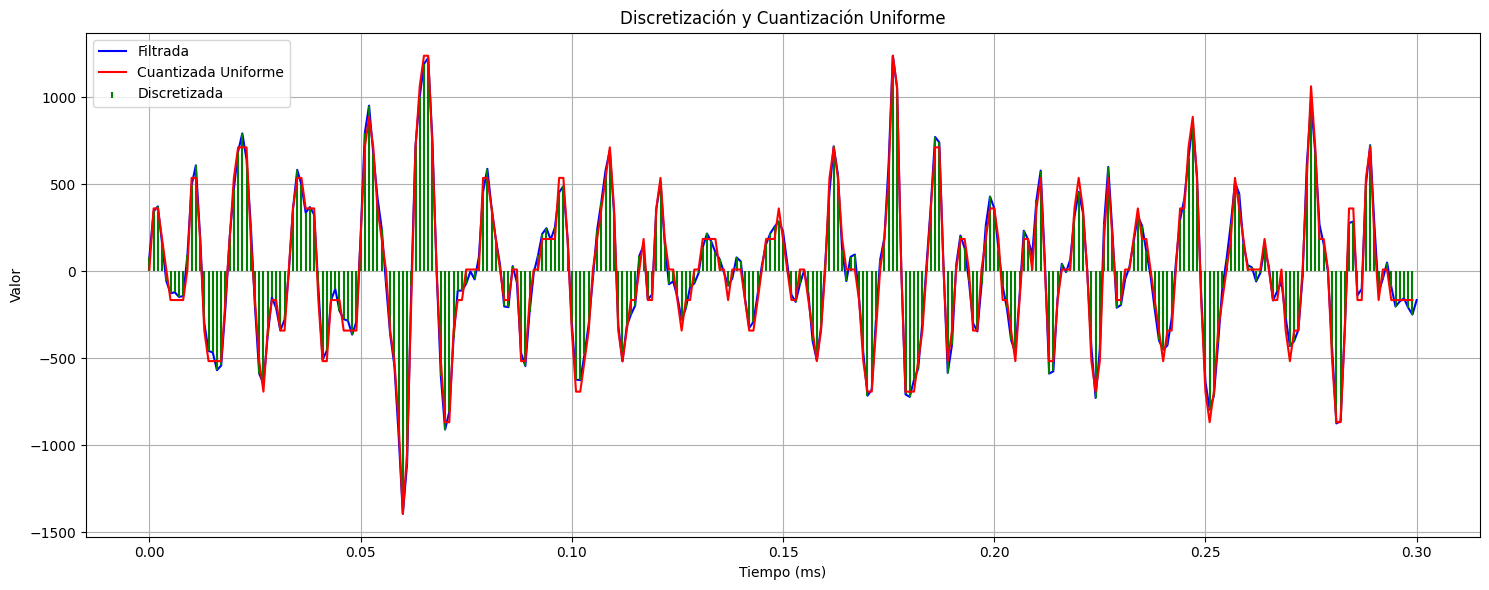

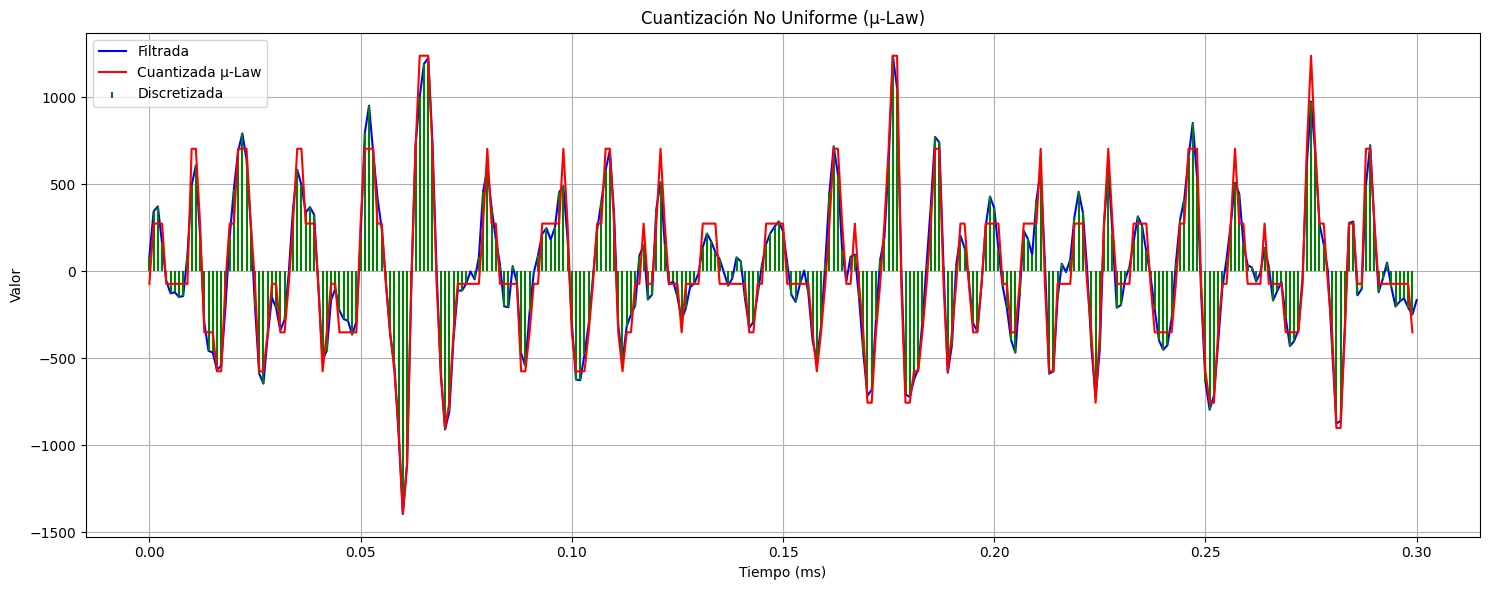

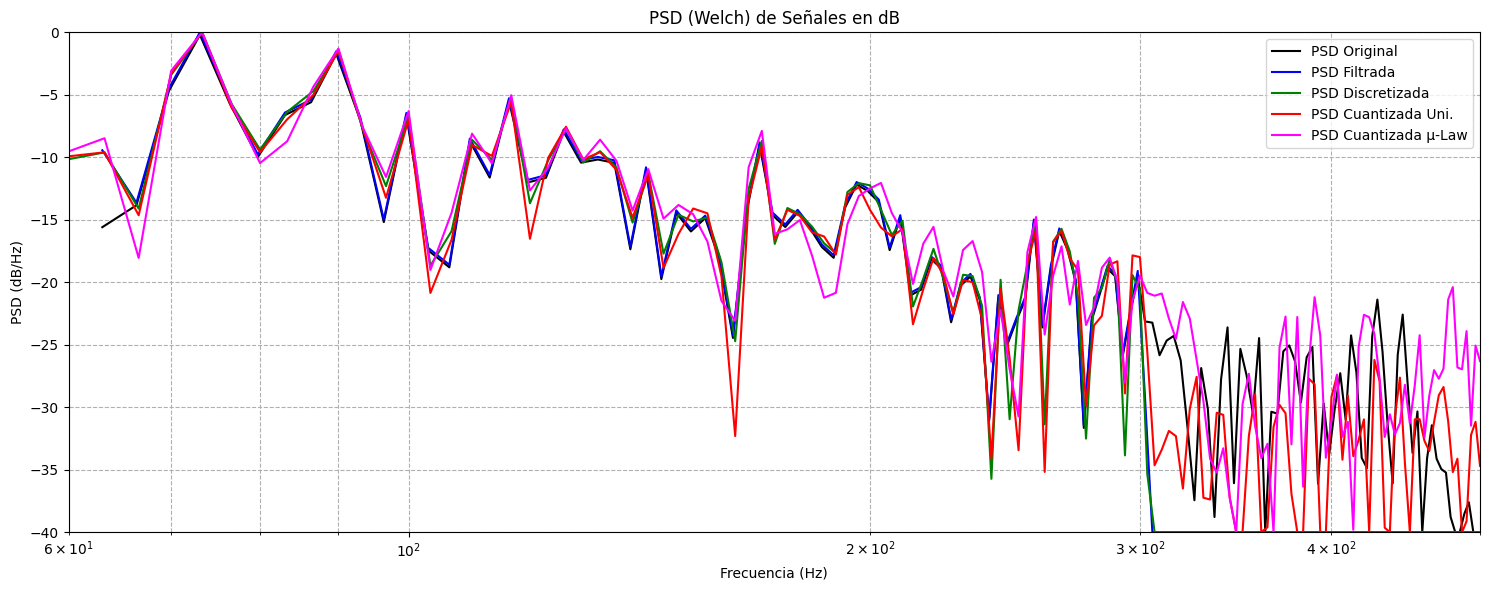


Total bits: 38620 (Esperados: 38620)
1's: 19105 | 0's: 19515


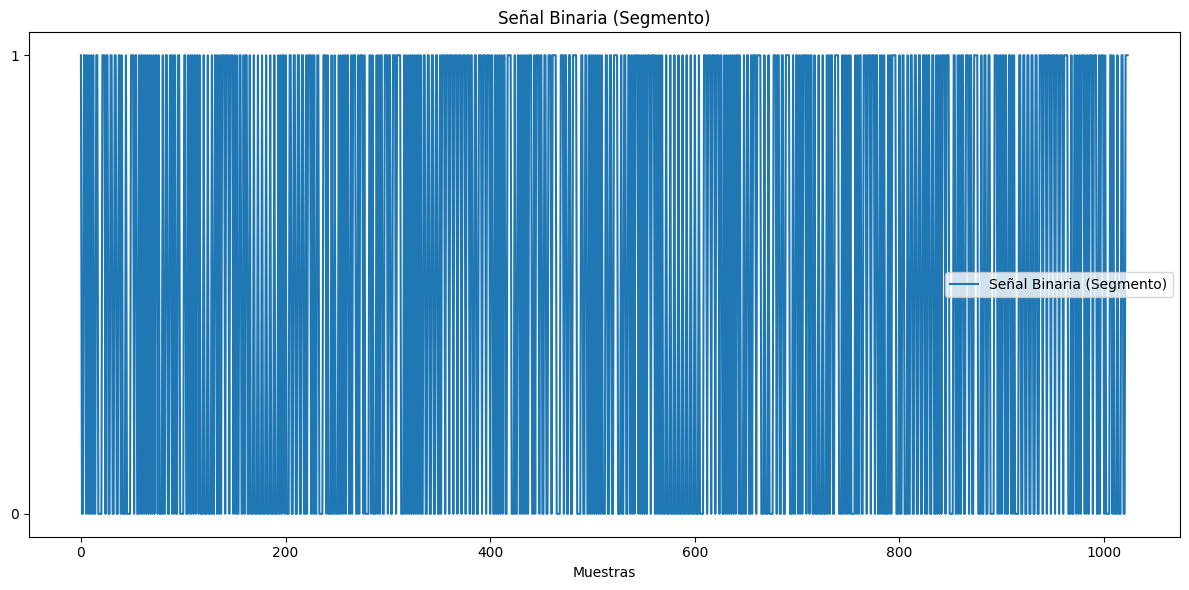


Huffman: 38620 bits | 1's: 19515 | 0's: 19105


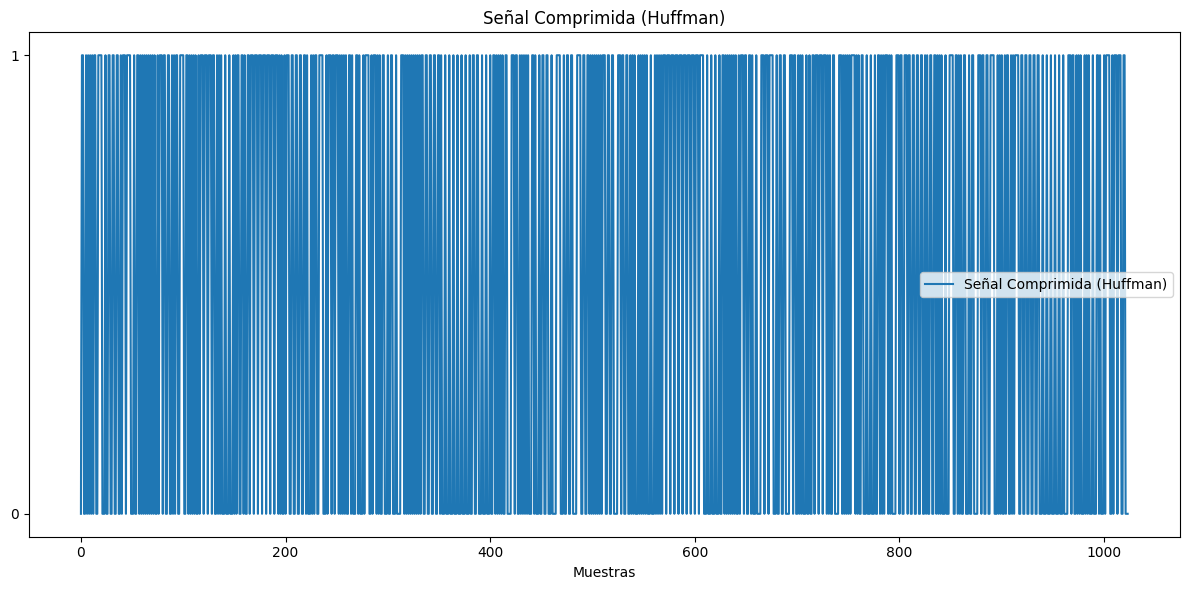

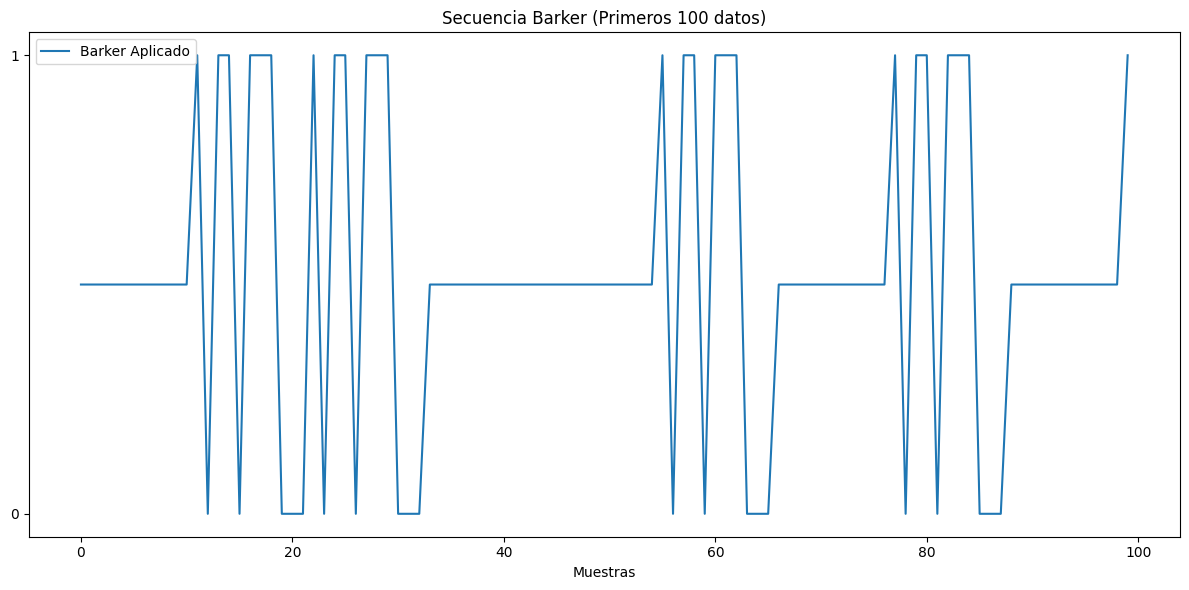

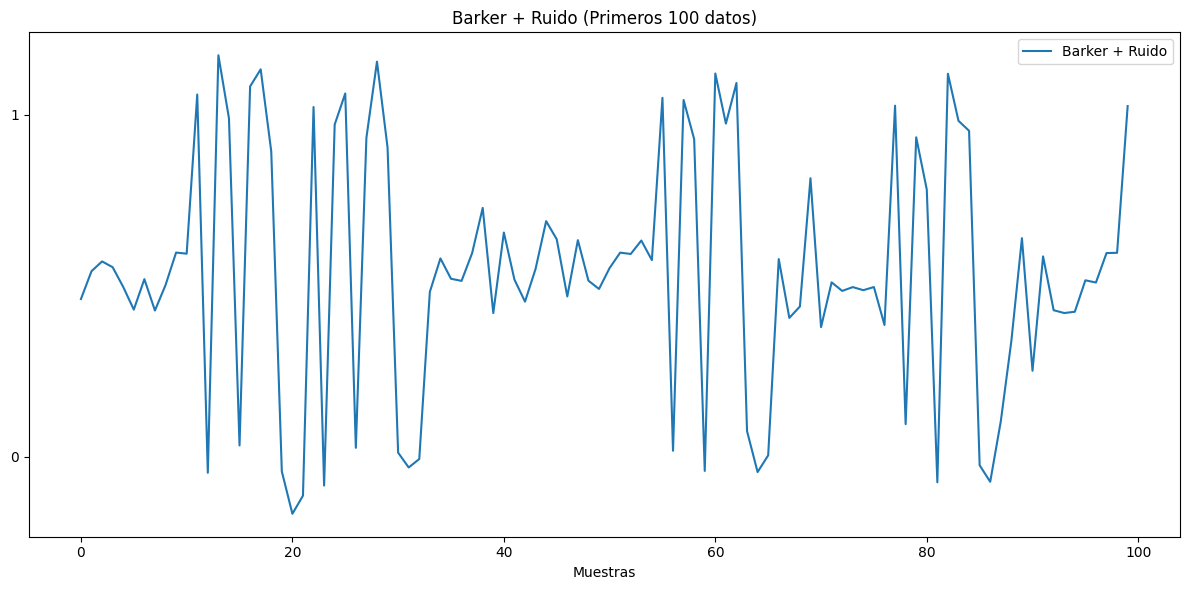

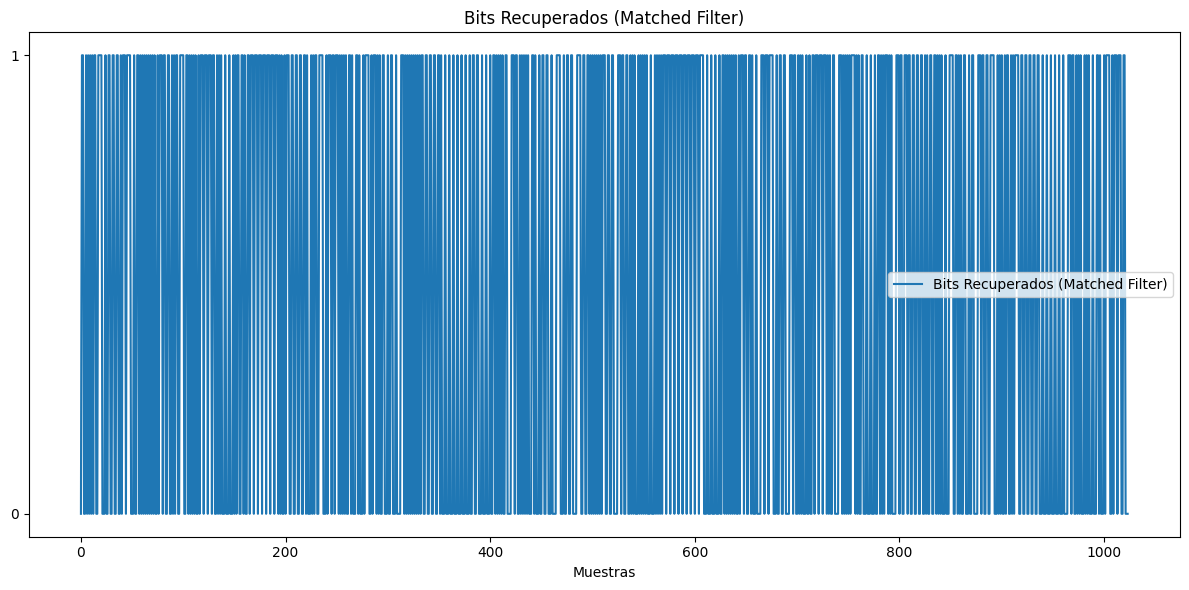

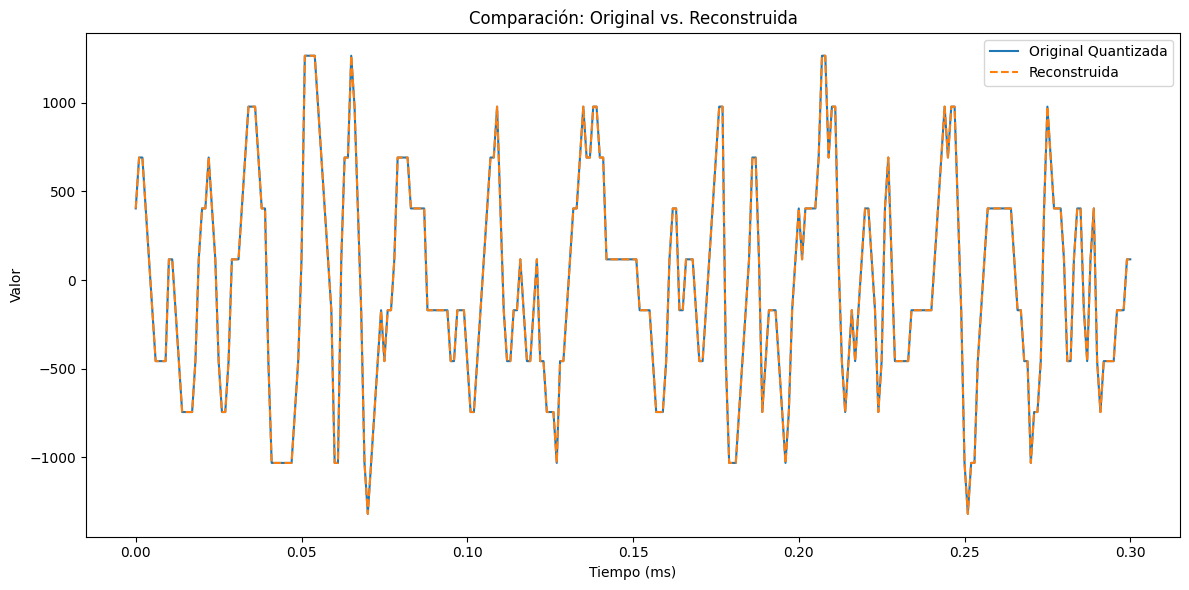

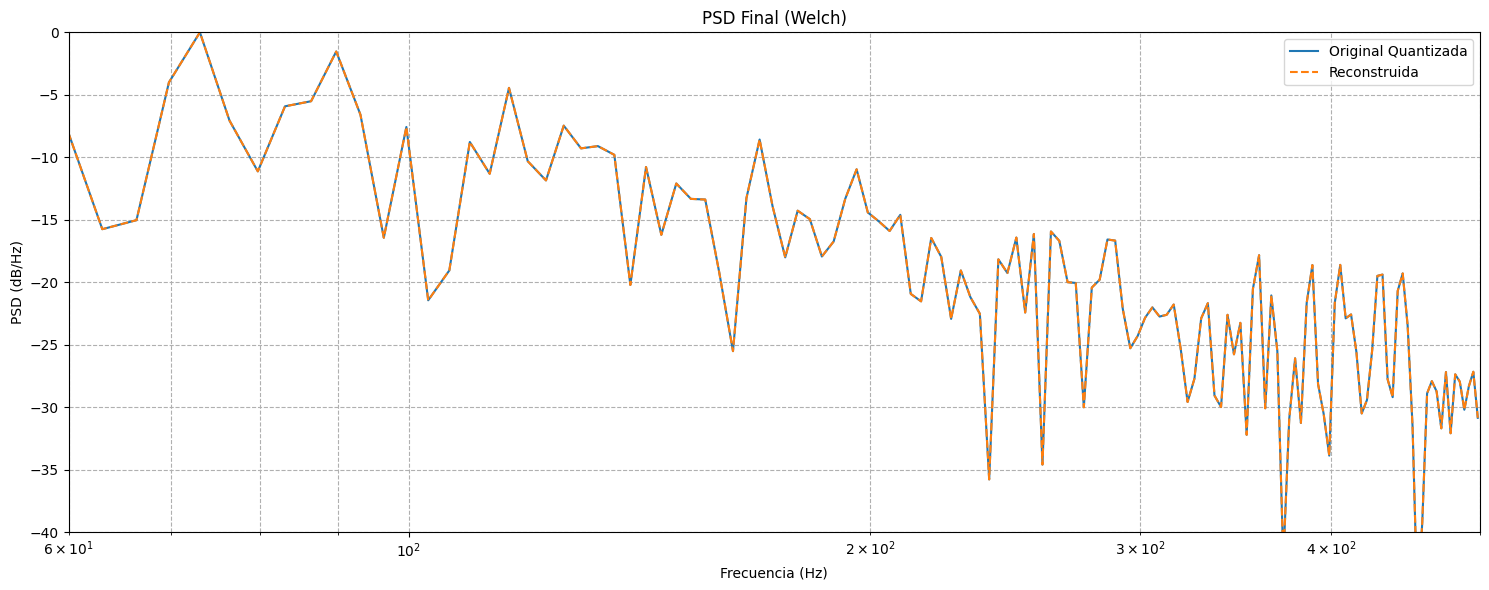

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from scipy.fftpack import fft, fftfreq, ifft
from scipy.signal import welch
import heapq

# =============================================================================
# Clase para compresión y descompresión Huffman
# =============================================================================
class HuffmanProcessor:
    """
    Compresión y descompresión de datos mediante el algoritmo de Huffman.
    """
    class HuffmanNode:
        def __init__(self, symbol, freq):
            self.symbol = symbol
            self.freq = freq
            self.left = None
            self.right = None

        def __lt__(self, other):
            return self.freq < other.freq

    @staticmethod
    def build_tree(data):
        """Construye el árbol de Huffman a partir de la secuencia de datos."""
        freq = {}
        for ch in data:
            freq[ch] = freq.get(ch, 0) + 1
        heap = [HuffmanProcessor.HuffmanNode(symbol, f) for symbol, f in freq.items()]
        heapq.heapify(heap)
        while len(heap) > 1:
            node1 = heapq.heappop(heap)
            node2 = heapq.heappop(heap)
            merged = HuffmanProcessor.HuffmanNode(None, node1.freq + node2.freq)
            merged.left, merged.right = node1, node2
            heapq.heappush(heap, merged)
        return heap[0]

    @staticmethod
    def generate_codes(node, prefix=""):
        """Genera el diccionario de códigos para la compresión Huffman."""
        if node is None:
            return {}
        if node.symbol is not None:
            return {node.symbol: prefix}
        codes = HuffmanProcessor.generate_codes(node.left, prefix + "0")
        codes.update(HuffmanProcessor.generate_codes(node.right, prefix + "1"))
        return codes

    @staticmethod
    def compress(data):
        """
        Comprime la secuencia de bits usando Huffman.

        Returns:
            tuple: (encoded_data, codebook)
        """
        root = HuffmanProcessor.build_tree(data)
        codebook = HuffmanProcessor.generate_codes(root)
        encoded_data = ''.join(codebook[ch] for ch in data)
        return encoded_data, codebook

    @staticmethod
    def decompress(encoded_data, codebook):
        """
        Descomprime la secuencia comprimida.

        Returns:
            str: Secuencia original.
        """
        inv_codebook = {v: k for k, v in codebook.items()}
        decoded, temp = "", ""
        for bit in encoded_data:
            temp += bit
            if temp in inv_codebook:
                decoded += inv_codebook[temp]
                temp = ""
        return decoded

# =============================================================================
# Clase para procesar la secuencia de Barker
# =============================================================================
class BarkerProcessor:
    """
    Aplica la secuencia de Barker, agrega ruido y recupera la secuencia mediante matched filtering.
    """
    def __init__(self, barker_sequence):
        """
        Inicializa la clase con la secuencia de Barker.

        Parameters:
            barker_sequence (list): Secuencia de Barker (ej. [1, -1, 1, 1, -1, ...]).
        """
        self.barker_sequence = np.array(barker_sequence)

    def apply_barker(self, signal):
        """
        Expande cada bit: '1' se reemplaza por la secuencia de Barker y '0' por ceros.
        """
        return np.concatenate([self.barker_sequence if bit == '1'
                               else np.zeros_like(self.barker_sequence)
                               for bit in signal])

    def add_noise(self, signal, noise_mean=0, noise_std=0.2):
        """Agrega ruido gaussiano blanco a la señal."""
        return signal + np.random.normal(noise_mean, noise_std, size=signal.shape)

    def matched_filter(self, received_signal, threshold=None):
        """
        Aplica matched filtering para detectar la secuencia.

        Returns:
            str: Secuencia binaria recuperada.
        """
        L = len(self.barker_sequence)
        if threshold is None:
            threshold = np.sum(self.barker_sequence ** 2) / 2
        recovered = []
        for i in range(0, len(received_signal), L):
            block = received_signal[i:i+L]
            if len(block) < L:
                break
            recovered.append("1" if np.dot(block, self.barker_sequence) > threshold else "0")
        return "".join(recovered)

# =============================================================================
# Procesamiento en el dominio del tiempo
# =============================================================================
class TimeDomainProcessor:
    """
    Carga, filtra y analiza la señal en el dominio del tiempo.
    """
    def __init__(self, csv_path, tiempo_a_graficar=0.3):
        self.csv_path = csv_path
        self.tiempo_a_graficar = tiempo_a_graficar
        self.tiempo = self.señal = None
        self.tiempo_filtrado = self.señal_filtrada = None
        self.N_filtrado = self.T = self.fs = None
        self.y_f = self.frecuencias = None
        self.f_min = self.f_max = None
        self.y_f_filtrado = self.señal_filtrada_freq = None

    def mount_drive(self):
        """Monta el drive de Google Colab."""
        drive.mount('/content/drive')

    def load_and_filter(self):
        """Carga el CSV, filtra la señal y calcula parámetros básicos."""
        try:
            datos = pd.read_csv(self.csv_path)
            print("Archivo CSV cargado exitosamente.")
        except Exception as e:
            print(f"Error al cargar el archivo CSV: {e}")
            exit()
        if 'Tiempo (ms)' in datos.columns and 'Datos Columna 2' in datos.columns:
            datos['Tiempo (ms)'] = pd.to_numeric(datos['Tiempo (ms)'], errors='coerce')
            self.tiempo = datos['Tiempo (ms)'].values
            self.señal = datos['Datos Columna 2'].values
            mask = self.tiempo <= self.tiempo_a_graficar
            self.tiempo_filtrado, self.señal_filtrada = self.tiempo[mask], self.señal[mask]
            self.N_filtrado = len(self.señal_filtrada)
            self.T = np.mean(np.diff(self.tiempo_filtrado))
            self.fs = 1 / self.T
            print(f"Puntos: {self.N_filtrado} | fs: {self.fs:.4f} Hz")
        else:
            print("Error: El CSV no contiene las columnas requeridas.")
            exit()

    def compute_fft(self):
        """Calcula la FFT de la señal filtrada."""
        self.y_f = fft(self.señal_filtrada)
        self.frecuencias = fftfreq(self.N_filtrado, d=self.T)
        positive_freqs = np.abs(self.frecuencias[self.frecuencias > 0])
        print(f"f_min: {np.min(positive_freqs):.4f} Hz | f_max: {np.max(positive_freqs):.4f} Hz")

    def apply_bandpass_filter(self, f_min, f_max):
        """
        Aplica un filtro pasabanda en el dominio de la frecuencia.

        Parameters:
            f_min (float): Frecuencia mínima.
            f_max (float): Frecuencia máxima.
        """
        self.f_min, self.f_max = f_min, f_max
        filtro = (np.abs(self.frecuencias) >= f_min) & (np.abs(self.frecuencias) <= f_max)
        self.y_f_filtrado = self.y_f * filtro
        self.señal_filtrada_freq = np.real(ifft(self.y_f_filtrado))
        print(f"Filtro: {f_min} Hz a {f_max} Hz")

    def plot_time_domain(self):
        """Grafica la señal original y la señal filtrada."""
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada, 'b-', label='Original')
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, 'g-', label='Filtrada')
        plt.title(f'Señal EMG (Filtro: {self.f_min}-{self.f_max} Hz)')
        plt.xlabel('Tiempo (ms)')
        plt.ylabel('Valor')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# =============================================================================
# Discretización y cuantización
# =============================================================================
class DiscreteQuantProcessor:
    """
    Realiza la discretización y cuantización (uniforme y μ‑Law) de la señal.
    """
    def __init__(self, tiempo_filtrado, señal_filtrada_freq):
        self.tiempo_filtrado = tiempo_filtrado
        self.señal_filtrada_freq = señal_filtrada_freq

    def discretize_signal(self, sampling_rate=1000):
        """Discretiza la señal por interpolación."""
        # Se usa el vector de tiempo filtrado para definir el intervalo
        t_discreto = np.arange(self.tiempo_filtrado[0], self.tiempo_filtrado[-1], 1/sampling_rate)
        return t_discreto, np.interp(t_discreto, self.tiempo_filtrado, self.señal_filtrada_freq)

    @staticmethod
    def quantize_uniform(x, q_min, q_max, q_level):
        """Cuantización uniforme de la señal."""
        xn = (x - q_min) * (q_level - 1) / (q_max - q_min)
        return np.round(np.clip(xn, 0, q_level - 1)) * (q_max - q_min) / (q_level - 1) + q_min

    @staticmethod
    def quantize_mu_law(signal, L=16, mu=255, x_min=None, x_max=None):
        """Cuantización no uniforme usando la ley μ‑Law."""
        x_min = signal.min() if x_min is None else x_min
        x_max = signal.max() if x_max is None else x_max
        x_norm = (signal - x_min) / (x_max - x_min)
        companded = np.log1p(mu * x_norm) / np.log1p(mu)
        q_companded = np.round(companded * (L - 1)) / (L - 1)
        return (np.expm1(q_companded * np.log1p(mu)) / mu) * (x_max - x_min) + x_min

    def plot_discretized_quantized(self, t_discreto, señal_discreta, señal_quant_uniform):
        """Grafica la señal discretizada y cuantizada uniformemente."""
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, 'b-', label='Filtrada')
        plt.stem(t_discreto, señal_discreta, linefmt='g-', markerfmt=' ', basefmt=' ', label='Discretizada')
        plt.plot(t_discreto, señal_quant_uniform, 'r-', label='Cuantizada Uniforme')
        plt.xlabel('Tiempo (ms)')
        plt.ylabel('Valor')
        plt.title('Discretización y Cuantización Uniforme')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_quantized_mu(self, t_discreto, señal_quant_mu):
        """Grafica la señal cuantizada con μ‑Law."""
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, 'b-', label='Filtrada')
        plt.stem(t_discreto, np.interp(t_discreto, self.tiempo_filtrado, self.señal_filtrada_freq),
                  linefmt='g-', markerfmt=' ', basefmt=' ', label='Discretizada')
        plt.plot(t_discreto, señal_quant_mu, 'r-', label='Cuantizada μ‑Law')
        plt.xlabel('Tiempo (ms)')
        plt.ylabel('Valor')
        plt.title('Cuantización No Uniforme (μ‑Law)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# =============================================================================
# Análisis de la PSD
# =============================================================================
class PSDProcessor:
    """
    Calcula y grafica la densidad espectral de potencia (PSD) usando el método de Welch.
    """
    def __init__(self, fs, f_min):
        self.fs, self.f_min = fs, f_min

    def plot_psd(self, señal_original, señal_filtrada, señal_discreta, señal_qunif, señal_qmu, eps=1e-12):
        def calc_psd(signal):
            n = min(1024, len(signal))
            f, psd = welch(signal, self.fs, nperseg=n)
            psd_db = 10 * np.log10(psd + eps)
            return f, np.clip(psd_db - psd_db.max(), -40, 0)
        f1, psd1 = calc_psd(señal_original)
        f2, psd2 = calc_psd(señal_filtrada)
        f3, psd3 = calc_psd(señal_discreta)
        f4, psd4 = calc_psd(señal_qunif)
        f5, psd5 = calc_psd(señal_qmu)
        plt.figure(figsize=(15, 6))
        for f, psd, label, col in zip([f1, f2, f3, f4, f5],
                                      [psd1, psd2, psd3, psd4, psd5],
                                      ['Original', 'Filtrada', 'Discretizada', 'Cuantizada Uni.', 'Cuantizada μ‑Law'],
                                      ['black', 'blue', 'green', 'red', 'magenta']):
            plt.plot(f[f>=self.f_min], psd[f>=self.f_min], color=col, label=f'PSD {label}')
        plt.title('PSD (Welch) de Señales en dB')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('PSD (dB/Hz)')
        plt.xscale('log')
        plt.xlim(self.f_min, 500)
        plt.ylim(-40, 0)
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.tight_layout()
        plt.show()

# =============================================================================
# Clase que orquesta todo el procesamiento
# =============================================================================
class MainProcessor:
    """
    Orquesta la lectura, filtrado, discretización, cuantización, análisis espectral,
    compresión (Huffman) y el procesamiento con secuencia de Barker para la señal.
    """
    def __init__(self, csv_path, tiempo_a_graficar=0.3):
        self.csv_path, self.tiempo_a_graficar = csv_path, tiempo_a_graficar

    def run(self):
        # Función auxiliar para graficar secuencias de bits
        def plot_bits(signal, title, sample_count=1024):
            plt.figure(figsize=(12, 6))
            plt.plot(signal[:sample_count], label=title)
            plt.title(title)
            plt.xlabel("Muestras")
            plt.yticks([0, 1])
            plt.legend()
            plt.tight_layout()
            plt.show()

        # Etapas previas: carga, filtrado y análisis de frecuencia
        tdp = TimeDomainProcessor(self.csv_path, self.tiempo_a_graficar)
        tdp.mount_drive()
        tdp.load_and_filter()
        tdp.compute_fft()
        try:
            f_min = float(input("Ingresa f_min (Hz): "))
            f_max = float(input("Ingresa f_max (Hz): "))
        except Exception as e:
            print("Error en los valores de frecuencia:", e)
            exit()
        tdp.apply_bandpass_filter(f_min, f_max)
        tdp.plot_time_domain()

        # Discretización y cuantización
        dq = DiscreteQuantProcessor(tdp.tiempo_filtrado, tdp.señal_filtrada_freq)
        t_discreto, señal_discreta = dq.discretize_signal(sampling_rate=1000)
        num_bits, levels = 4, 2 ** 4
        q_min, q_max = señal_discreta.min(), señal_discreta.max()
        señal_qunif = dq.quantize_uniform(señal_discreta, q_min, q_max, levels)
        señal_qmu = dq.quantize_mu_law(señal_discreta, L=levels, mu=25)
        dq.plot_discretized_quantized(t_discreto, señal_discreta, señal_qunif)
        dq.plot_quantized_mu(t_discreto, señal_qmu)

        # Análisis PSD
        PSDProcessor(tdp.fs, f_min).plot_psd(tdp.señal_filtrada, tdp.señal_filtrada_freq,
                                              señal_discreta, señal_qunif, señal_qmu)

        # Representación binaria y compresión Huffman (sobre la señal completa)
        qmin_c, qmax_c = tdp.señal.min(), tdp.señal.max()
        complete_quant = dq.quantize_uniform(tdp.señal, qmin_c, qmax_c, levels)
        binary_sequence = ''.join(format(int(round((x - qmin_c) * (levels - 1) / (qmax_c - qmin_c))),
                                          f'0{num_bits}b') for x in complete_quant)
        print(f"\nTotal bits: {len(binary_sequence)} (Esperados: {len(tdp.señal)*num_bits})")
        print(f"1's: {binary_sequence.count('1')} | 0's: {binary_sequence.count('0')}")
        plot_bits([int(b) for b in binary_sequence], "Señal Binaria (Segmento)")

        huff_encoded, huff_codebook = HuffmanProcessor.compress(binary_sequence)
        print(f"\nHuffman: {len(huff_encoded)} bits | 1's: {huff_encoded.count('1')} | 0's: {huff_encoded.count('0')}")
        plot_bits([int(b) for b in huff_encoded], "Señal Comprimida (Huffman)")

        # Procesamiento con Barker
        barker_seq = [1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1]
        barker_proc = BarkerProcessor(barker_seq)
        barker_applied = barker_proc.apply_barker(huff_encoded)
        plt.figure(figsize=(12, 6))
        plt.plot(((barker_applied + 1) / 2)[:100], label="Barker Aplicado")
        plt.title("Secuencia Barker (Primeros 100 datos)")
        plt.xlabel("Muestras")
        plt.yticks([0, 1])
        plt.legend()
        plt.tight_layout()
        plt.show()

        noisy = barker_proc.add_noise(barker_applied)
        plt.figure(figsize=(12, 6))
        plt.plot(((noisy + 1) / 2)[:100], label="Barker + Ruido")
        plt.title("Barker + Ruido (Primeros 100 datos)")
        plt.xlabel("Muestras")
        plt.yticks([0, 1])
        plt.legend()
        plt.tight_layout()
        plt.show()

        recovered = barker_proc.matched_filter(noisy)
        plot_bits([int(b) for b in recovered], "Bits Recuperados (Matched Filter)")

        # Reconstrucción: descomprimir y mapear a niveles
        decompressed = HuffmanProcessor.decompress(recovered, huff_codebook)
        rec_levels = np.array([int(decompressed[i:i+num_bits], 2) for i in range(0, len(decompressed), num_bits)])
        reconstructed = qmin_c + rec_levels * (qmax_c - qmin_c) / (levels - 1)

        mask = tdp.tiempo <= self.tiempo_a_graficar
        plt.figure(figsize=(12, 6))
        plt.plot(tdp.tiempo[mask], complete_quant[mask], label="Original Quantizada")
        plt.plot(tdp.tiempo[mask], reconstructed[mask], '--', label="Reconstruida")
        plt.title("Comparación: Original vs. Reconstruida")
        plt.xlabel("Tiempo (ms)")
        plt.ylabel("Valor")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # PSD final de señales originales y reconstruidas
        n = min(1024, mask.sum())
        f_orig, psd_orig = welch(complete_quant[mask], tdp.fs, nperseg=n)
        f_rec, psd_rec = welch(reconstructed[mask], tdp.fs, nperseg=n)
        plt.figure(figsize=(15, 6))
        plt.plot(f_orig, 10 * np.log10(psd_orig + 1e-12) - (10 * np.log10(psd_orig + 1e-12)).max(), label="Original Quantizada")
        plt.plot(f_rec, 10 * np.log10(psd_rec + 1e-12) - (10 * np.log10(psd_rec + 1e-12)).max(), '--', label="Reconstruida")
        plt.title("PSD Final (Welch)")
        plt.xlabel("Frecuencia (Hz)")
        plt.ylabel("PSD (dB/Hz)")
        plt.xscale("log")
        plt.xlim(f_min, 500)
        plt.ylim(-40, 0)
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.tight_layout()
        plt.show()

# =============================================================================
# Ejecución principal
# =============================================================================
if __name__ == "__main__":
    csv_path = "/content/drive/MyDrive/Signal Theory/Running_Columna_2_Tiempo.csv"
    MainProcessor(csv_path, tiempo_a_graficar=0.3).run()
